In [1]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000


In [2]:
train_raw = pd.read_csv('train.csv')
train = train_raw.copy()

In [3]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train_raw['Id']
train.drop(['Id'], axis=1, inplace=True)
train_raw.drop(['Id'], axis=1, inplace=True)

In [4]:
train.shape, train_raw.shape

((1460, 80), (1460, 80))

In [5]:
train_ID.shape

(1460,)

# Feature fix


In [6]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])


 mu = 12.02 and sigma = 0.40



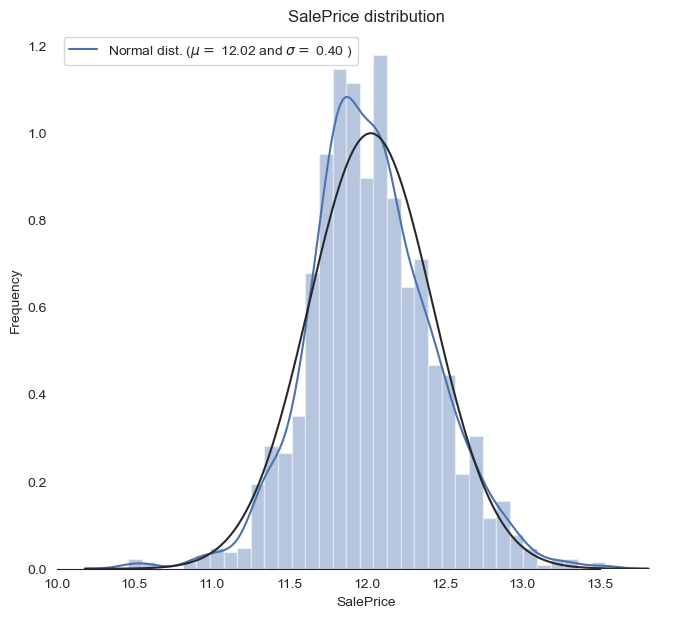

In [7]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [8]:
train_raw_labels = train['SalePrice'].reset_index(drop=True)

In [9]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [10]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)

In [11]:
train_raw_features = train_raw.drop(['SalePrice'], axis=1)

In [12]:
train_features.shape, train_raw_features.shape

((1458, 79), (1460, 79))

# FILL MISSING VALUES

In [13]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})

    return dict_x

missing = percent_missing(train_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.59),
 ('MiscFeature', 96.3),
 ('Alley', 93.76),
 ('Fence', 80.73),
 ('FireplaceQu', 47.33),
 ('LotFrontage', 17.76),
 ('GarageType', 5.56),
 ('GarageYrBlt', 5.56),
 ('GarageFinish', 5.56),
 ('GarageQual', 5.56)]

In [14]:
missing = percent_missing(train_raw_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.52),
 ('MiscFeature', 96.3),
 ('Alley', 93.77),
 ('Fence', 80.75),
 ('FireplaceQu', 47.26),
 ('LotFrontage', 17.74),
 ('GarageType', 5.55),
 ('GarageYrBlt', 5.55),
 ('GarageFinish', 5.55),
 ('GarageQual', 5.55)]

In [15]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings
train_raw_features['MSSubClass'] = train_raw_features['MSSubClass'].apply(str)
train_raw_features['YrSold'] = train_raw_features['YrSold'].astype(str)
train_raw_features['MoSold'] = train_raw_features['MoSold'].astype(str)

In [16]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings
train_features['MSSubClass'] = train_features['MSSubClass'].apply(str)
train_features['YrSold'] = train_features['YrSold'].astype(str)
train_features['MoSold'] = train_features['MoSold'].astype(str)

In [17]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')

    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))

    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))
    return features

train_features = handle_missing(train_features)
train_raw_features = handle_missing(train_raw_features)

In [18]:
# Let's make sure we handled all the missing values
missing = percent_missing(train_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

In [19]:
# Let's make sure we handled all the missing values
missing = percent_missing(train_raw_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

# SKEWED FEATURES FIX

In [20]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train_features.columns:
    if train_features[i].dtype in numeric_dtypes:
        numeric.append(i)

In [21]:
# Find skewed numerical features
skew_features = train_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          24.434913
PoolArea         15.932532
LotArea          12.560986
3SsnPorch        10.286510
LowQualFinSF      8.995688
KitchenAbvGr      4.480268
BsmtFinSF2        4.247550
ScreenPorch       4.114690
BsmtHalfBath      4.095895
EnclosedPorch     3.083987
dtype: float64

In [22]:
# Normalize skewed features
for i in skew_index:
    train_features[i] = boxcox1p(train_features[i], boxcox_normmax(train_features[i] + 1))

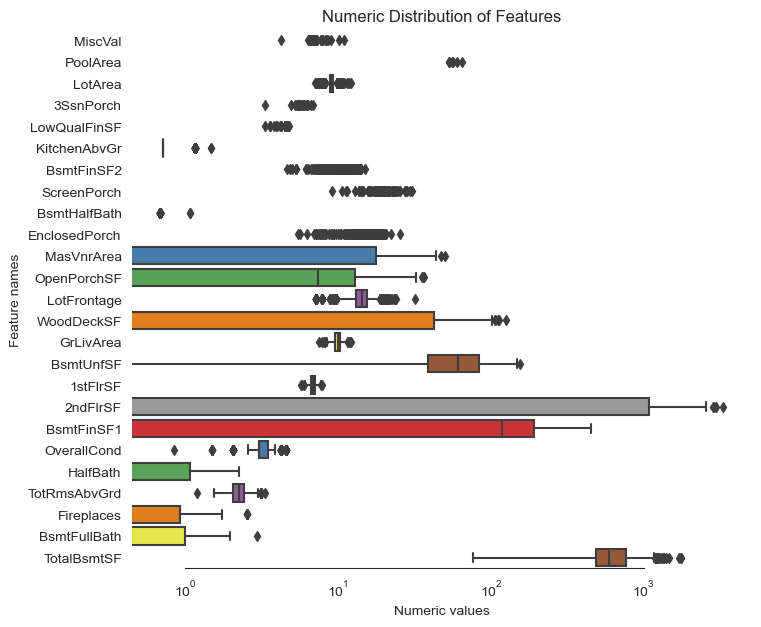

In [23]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=train_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [24]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train_raw_features.columns:
    if train_raw_features[i].dtype in numeric_dtypes:
        numeric.append(i)

# Find skewed numerical features
skew_features = train_raw_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})

# Normalize skewed features
for i in skew_index:
    train_raw_features[i] = boxcox1p(train_raw_features[i], boxcox_normmax(train_raw_features[i] + 1))

There are 25 numerical features with Skew > 0.5 :


# COMPLEX FEATURES

In [25]:
train_features['BsmtFinType1_Unf'] = 1*(train_features['BsmtFinType1'] == 'Unf')
train_features['HasWoodDeck'] = (train_features['WoodDeckSF'] == 0) * 1
train_features['HasOpenPorch'] = (train_features['OpenPorchSF'] == 0) * 1
train_features['HasEnclosedPorch'] = (train_features['EnclosedPorch'] == 0) * 1
train_features['Has3SsnPorch'] = (train_features['3SsnPorch'] == 0) * 1
train_features['HasScreenPorch'] = (train_features['ScreenPorch'] == 0) * 1
train_features['YearsSinceRemodel'] = train_features['YrSold'].astype(int) - train_features['YearRemodAdd'].astype(int)
train_features['Total_Home_Quality'] = train_features['OverallQual'] + train_features['OverallCond']
train_features = train_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
train_features['TotalSF'] = train_features['TotalBsmtSF'] + train_features['1stFlrSF'] + train_features['2ndFlrSF']
train_features['YrBltAndRemod'] = train_features['YearBuilt'] + train_features['YearRemodAdd']

train_features['Total_sqr_footage'] = (train_features['BsmtFinSF1'] + train_features['BsmtFinSF2'] +
                                 train_features['1stFlrSF'] + train_features['2ndFlrSF'])
train_features['Total_Bathrooms'] = (train_features['FullBath'] + (0.5 * train_features['HalfBath']) +
                               train_features['BsmtFullBath'] + (0.5 * train_features['BsmtHalfBath']))
train_features['Total_porch_sf'] = (train_features['OpenPorchSF'] + train_features['3SsnPorch'] +
                              train_features['EnclosedPorch'] + train_features['ScreenPorch'] +
                              train_features['WoodDeckSF'])
train_features['TotalBsmtSF'] = train_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
train_features['2ndFlrSF'] = train_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
train_features['GarageArea'] = train_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
train_features['GarageCars'] = train_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
train_features['LotFrontage'] = train_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
train_features['MasVnrArea'] = train_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
train_features['BsmtFinSF1'] = train_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

train_features['haspool'] = train_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_features['has2ndfloor'] = train_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train_features['hasgarage'] = train_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train_features['hasbsmt'] = train_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_features['hasfireplace'] = train_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


In [26]:
# train_raw_features['BsmtFinType1_Unf'] = 1*(train_raw_features['BsmtFinType1'] == 'Unf')
# train_raw_features['HasWoodDeck'] = (train_raw_features['WoodDeckSF'] == 0) * 1
# train_raw_features['HasOpenPorch'] = (train_raw_features['OpenPorchSF'] == 0) * 1
# train_raw_features['HasEnclosedPorch'] = (train_raw_features['EnclosedPorch'] == 0) * 1
# train_raw_features['Has3SsnPorch'] = (train_raw_features['3SsnPorch'] == 0) * 1
# train_raw_features['HasScreenPorch'] = (train_raw_features['ScreenPorch'] == 0) * 1
# train_raw_features['YearsSinceRemodel'] = train_raw_features['YrSold'].astype(int) - train_raw_features['YearRemodAdd'].astype(int)
# train_raw_features['Total_Home_Quality'] = train_raw_features['OverallQual'] + train_raw_features['OverallCond']
# train_raw_features = train_raw_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
# train_raw_features['TotalSF'] = train_raw_features['TotalBsmtSF'] + train_raw_features['1stFlrSF'] + train_raw_features['2ndFlrSF']
# train_raw_features['YrBltAndRemod'] = train_raw_features['YearBuilt'] + train_raw_features['YearRemodAdd']

# train_raw_features['Total_sqr_footage'] = (train_raw_features['BsmtFinSF1'] + train_raw_features['BsmtFinSF2'] +
#                                  train_raw_features['1stFlrSF'] + train_raw_features['2ndFlrSF'])
# train_raw_features['Total_Bathrooms'] = (train_raw_features['FullBath'] + (0.5 * train_raw_features['HalfBath']) +
#                                train_raw_features['BsmtFullBath'] + (0.5 * train_raw_features['BsmtHalfBath']))
# train_raw_features['Total_porch_sf'] = (train_raw_features['OpenPorchSF'] + train_raw_features['3SsnPorch'] +
#                               train_raw_features['EnclosedPorch'] + train_raw_features['ScreenPorch'] +
#                               train_raw_features['WoodDeckSF'])
# train_raw_features['TotalBsmtSF'] = train_raw_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
# train_raw_features['2ndFlrSF'] = train_raw_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
# train_raw_features['GarageArea'] = train_raw_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
# train_raw_features['GarageCars'] = train_raw_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
# train_raw_features['LotFrontage'] = train_raw_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
# train_raw_features['MasVnrArea'] = train_raw_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
# train_raw_features['BsmtFinSF1'] = train_raw_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

# train_raw_features['haspool'] = train_raw_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# train_raw_features['has2ndfloor'] = train_raw_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# train_raw_features['hasgarage'] = train_raw_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# train_raw_features['hasbsmt'] = train_raw_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
# train_raw_features['hasfireplace'] = train_raw_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


# FEATURES TRANSFORMATION

In [27]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        if l not in res.columns:
            continue
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

train_features = logs(train_features, log_features)

In [28]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        if l not in res.columns:
            continue
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res

squared_features = ['YearRemodAdd', 'LotFrontage_log',
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
train_features = squares(train_features, squared_features)

# Encode categorical features

In [29]:
train_features = pd.get_dummies(train_features).reset_index(drop=True)
# Remove any duplicated column names
train_features = train_features.loc[:,~train_features.columns.duplicated()]
train_features.shape

(1458, 377)

In [30]:
# train_raw_features = pd.get_dummies(train_raw_features).reset_index(drop=True)
# # Remove any duplicated column names
# train_raw_features = train_raw_features.loc[:,~train_raw_features.columns.duplicated()]
# train_raw_features.shape

# Evaluate model vs model and raw vs preprocessed input data

In [31]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [32]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in train_raw_features.columns.values:
    if train_raw_features[col].dtypes == 'object':
        train_raw_features[col] = le.fit_transform(train_raw_features[col].astype(str))

In [33]:
train_features.shape, train_raw_features.shape

((1458, 377), (1460, 79))

In [34]:
train_labels.shape, train_raw_labels.shape

((1458,), (1460,))

In [35]:
import joblib
import os

In [156]:
models = [
          XGBRegressor(random_state = 42),
          GradientBoostingRegressor(random_state = 42),
          Ridge(random_state = 42),
          Lasso(random_state = 42),
          ElasticNet(random_state = 42),
         ]

def split_evaluate(dfraw, labelraw, dfprocessed, labelprocessed, n):
    output = pd.DataFrame(columns=['Seed', 'Model', 'Model_raw_MSE', 'Model_processed_MSE', 
                                   'Model_raw_rmse', 'Model_processed_rmse','Model_raw_rmsle',
                                   'Model_processed_rmsle', 'Model_raw_r2', 
                                   'Model_processed_r2', 'Model_raw_MAE', 'Model_processed_MAE'])
    for i in range(0,n):
        seed = i
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(dfraw, labelraw, test_size=0.2, random_state=seed)
        X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(dfprocessed, labelprocessed, test_size=0.2, random_state=seed)
        
        for model in models:
            # modelName = 'LR' if model == models[0] else 'XGB' if model == models[1] else 'GBR' if model == models[2] else 'SVR' if model == models[3] else 'Ridge' if model == models[4] else 'Lasso' if model == models[5] else 'ElasticNet'
            modelName = 'XGB' if model == models[0] else 'GBR' if model == models[1] else 'Ridge' if model == models[2] else 'Lasso' if model == models[3] else 'ElasticNet'
            if not os.path.exists(f'models/{modelName}/preprocess_eval'):
                os.makedirs(f'models/{modelName}/preprocess_eval')
            model_raw = model
            model_raw.fit(X_train_raw, y_train_raw)
            joblib.dump(model_raw, open(f'models/{modelName}/preprocess_eval/model_raw_{seed}.sav', 'wb'))
            y_pred_raw = model_raw.predict(X_test_raw)
            model_processed = model
            model_processed.fit(X_train_processed, y_train_processed)
            joblib.dump(model_processed, open(f'models/{modelName}/preprocess_eval/model_processed_{seed}.sav', 'wb'))
            y_pred_processed = model_processed.predict(X_test_processed)
            raw_MSE = mean_squared_error(y_test_raw, y_pred_raw)
            processed_MSE = mean_squared_error(y_test_processed, y_pred_processed)
            output = output.append({
                'Seed': seed, 'Model': modelName, 'Model_raw_MSE': raw_MSE, 'Model_processed_MSE': processed_MSE, 
                'Model_raw_rmse': np.sqrt(raw_MSE), 'Model_processed_rmse': np.sqrt(processed_MSE), 
                'Model_raw_rmsle': np.sqrt(mean_squared_log_error(y_test_raw, y_pred_raw)), 'Model_processed_rmsle': np.sqrt(mean_squared_log_error(y_test_processed, y_pred_processed)),
                'Model_raw_r2': r2_score(y_test_raw, y_pred_raw), 'Model_processed_r2': r2_score(y_test_processed, y_pred_processed), 
                'Model_raw_MAE': mean_absolute_error(y_test_raw, y_pred_raw), 
                'Model_processed_MAE': mean_absolute_error(y_test_processed, y_pred_processed)}, ignore_index=True)
    return output

def split_evaluate_wsaved_model(dfraw,labelraw, dfprocessed, labelprocessed,n):
    output = pd.DataFrame(columns=['Seed', 'Model', 'Model_raw_MSE', 'Model_processed_MSE', 
                                   'Model_raw_rmse', 'Model_processed_rmse','Model_raw_rmsle',
                                   'Model_processed_rmsle', 'Model_raw_r2', 
                                   'Model_processed_r2', 'Model_raw_MAE', 'Model_processed_MAE'])
    for i in range(0,n):
        seed = i
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(dfraw, labelraw, test_size=0.2, random_state=seed)
        X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(dfprocessed, labelprocessed, test_size=0.2, random_state=seed)

        for model in models:
            modelName = 'XGB' if model == models[0] else 'GBR' if model == models[1] else 'Ridge' if model == models[2] else 'Lasso' if model == models[3] else 'ElasticNet'
            model_raw = joblib.load(open(f'models/{modelName}/preprocess_eval/model_raw_{seed}.sav', 'rb'))
            y_pred_raw = model_raw.predict(X_test_raw)
            model_processed = joblib.load(open(f'models/{modelName}/preprocess_eval/model_processed_{seed}.sav', 'rb'))
            y_pred_processed = model_processed.predict(X_test_processed)
            raw_MSE = mean_squared_error(y_test_raw, y_pred_raw)
            processed_MSE = mean_squared_error(y_test_processed, y_pred_processed)
            output = output.append({
                'Seed': seed, 'Model': modelName, 'Model_raw_MSE': raw_MSE, 'Model_processed_MSE': processed_MSE, 
                'Model_raw_rmse': np.sqrt(raw_MSE), 'Model_processed_rmse': np.sqrt(processed_MSE), 
                'Model_raw_rmsle': np.sqrt(mean_squared_log_error(y_test_raw, y_pred_raw)), 'Model_processed_rmsle': np.sqrt(mean_squared_log_error(y_test_processed, y_pred_processed)),
                'Model_raw_r2': r2_score(y_test_raw, y_pred_raw), 'Model_processed_r2': r2_score(y_test_processed, y_pred_processed), 
                'Model_raw_MAE': mean_absolute_error(y_test_raw, y_pred_raw), 
                'Model_processed_MAE': mean_absolute_error(y_test_processed, y_pred_processed)}, ignore_index=True)
    return output

#create saved models

In [154]:
# CV = split_evaluate(train_raw_features, train_raw_labels, train_features, train_labels, 20)
# pd.DataFrame(CV)

run w/ saved models

In [157]:
CV = split_evaluate_wsaved_model(train_raw_features, train_raw_labels, train_features, train_labels, 20)
pd.DataFrame(CV)

,Seed,Model,Model_raw_MSE,Model_processed_MSE,Model_raw_rmse,Model_processed_rmse,Model_raw_rmsle,Model_processed_rmsle,Model_raw_r2,Model_processed_r2,Model_raw_MAE,Model_processed_MAE
0,0,XGB,0.019603,0.016547,0.140012,0.128636,0.010768,0.010016,0.870518,0.902361,0.098655,0.091135
1,0,GBR,0.015436,0.012194,0.124243,0.110424,0.009514,0.008547,0.898041,0.928050,0.087301,0.083510
2,0,Ridge,0.039160,0.011395,0.197888,0.106750,0.014937,0.008241,0.741346,0.932759,0.104724,0.078551
3,0,Lasso,0.058095,0.027601,0.241029,0.166135,0.017927,0.012878,0.616277,0.837137,0.141234,0.122617
4,0,ElasticNet,0.055196,0.025912,0.234938,0.160973,0.017453,0.012490,0.635426,0.847100,0.136158,0.117799
5,1,XGB,0.019746,0.020167,0.140521,0.142009,0.010877,0.011097,0.886224,0.873615,0.097454,0.101269
6,1,GBR,0.016232,0.014430,0.127403,0.120124,0.009998,0.009386,0.906475,0.909567,0.087271,0.086997
7,1,Ridge,0.018924,0.015605,0.137565,0.124922,0.010778,0.009816,0.890961,0.902200,0.093171,0.085314
8,1,Lasso,0.039283,0.032595,0.198199,0.180540,0.015483,0.014066,0.773657,0.795728,0.141463,0.132535
9,1,ElasticNet,0.036414,0.030638,0.190824,0.175038,0.014925,0.013647,0.790187,0.807989,0.136708,0.127119


In [39]:
CV.to_csv('CV.csv', index=False)

# Raw - Processed - Differece 

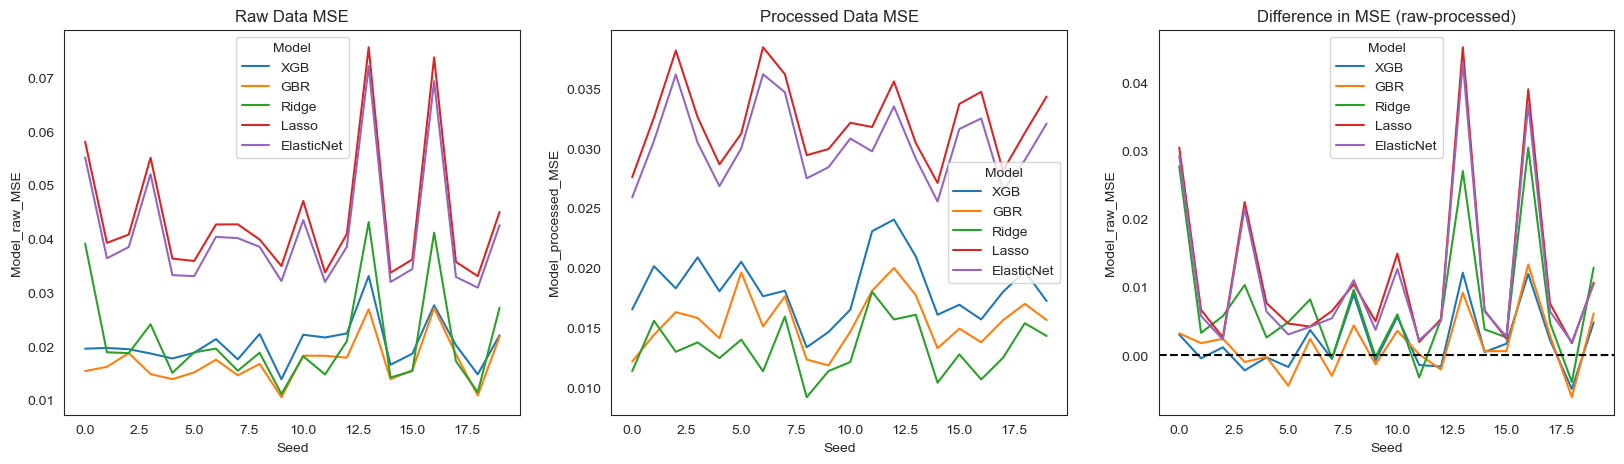

In [158]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_raw_MSE', hue='Model', data=CV, ax=ax[0])
sns.lineplot(x='Seed', y='Model_processed_MSE', hue='Model', data=CV, ax=ax[1])
CV_diff = CV.copy()
CV_diff['Model_raw_MSE'] = CV_diff['Model_raw_MSE'] - CV_diff['Model_processed_MSE']
sns.lineplot(x='Seed', y='Model_raw_MSE', hue='Model', data=CV_diff, ax=ax[2])
ax[2].axhline(y=0, color='black', linestyle='--')
ax[0].set_title('Raw Data MSE')
ax[1].set_title('Processed Data MSE')
ax[2].set_title('Difference in MSE (raw-processed)')
plt.show()


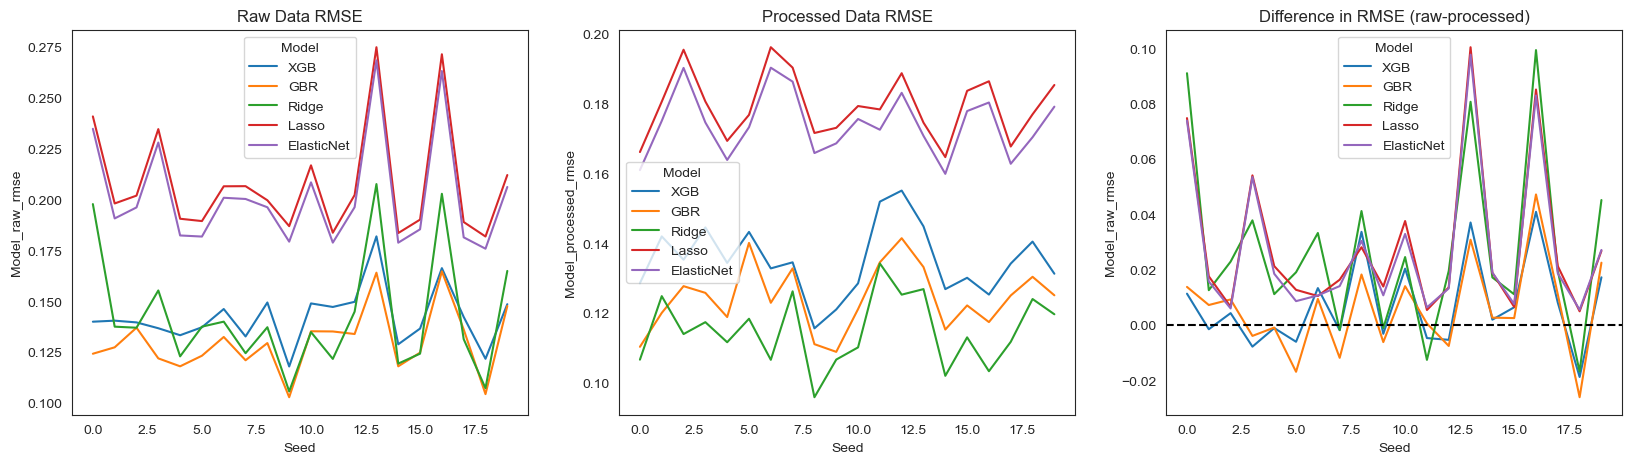

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_raw_rmse', hue='Model', data=CV, ax=ax[0])
sns.lineplot(x='Seed', y='Model_processed_rmse', hue='Model', data=CV, ax=ax[1])
CV_diff['Model_raw_rmse'] = CV_diff['Model_raw_rmse'] - CV_diff['Model_processed_rmse']
sns.lineplot(x='Seed', y='Model_raw_rmse', hue='Model', data=CV_diff, ax=ax[2])
ax[2].axhline(y=0, color='black', linestyle='--')
ax[0].set_title('Raw Data RMSE')
ax[1].set_title('Processed Data RMSE')
ax[2].set_title('Difference in RMSE (raw-processed)')
plt.show()

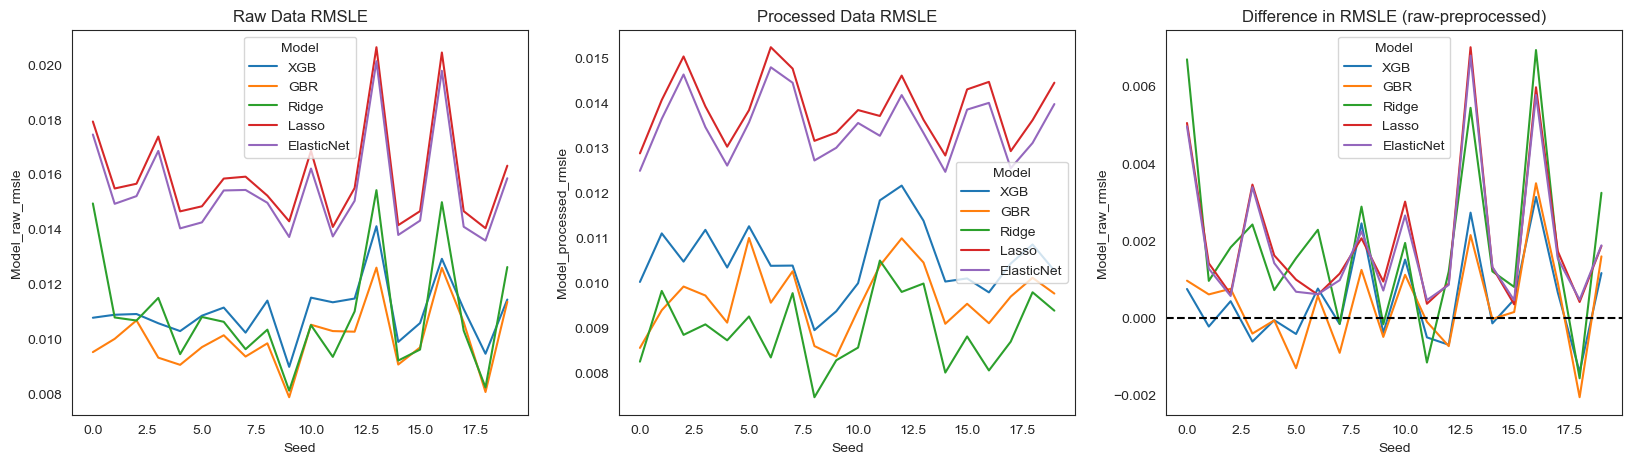

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_raw_rmsle', hue='Model', data=CV, ax=ax[0])
sns.lineplot(x='Seed', y='Model_processed_rmsle', hue='Model', data=CV, ax=ax[1])
CV_diff['Model_raw_rmsle'] = CV_diff['Model_raw_rmsle'] - CV_diff['Model_processed_rmsle']
sns.lineplot(x='Seed', y='Model_raw_rmsle', hue='Model', data=CV_diff, ax=ax[2])
ax[2].axhline(y=0, color='black', linestyle='--')
ax[0].set_title('Raw Data RMSLE')
ax[1].set_title('Processed Data RMSLE')
ax[2].set_title('Difference in RMSLE (raw-preprocessed)')
plt.show()

Text(0.5, 1.0, 'Difference in R2 (processed-raw)')

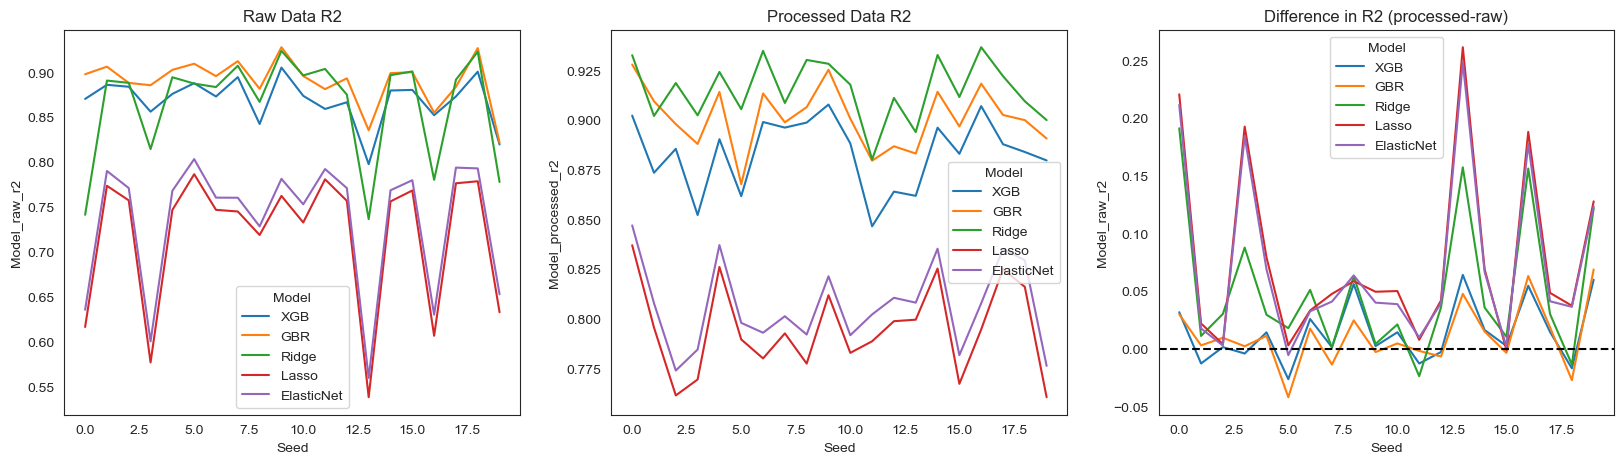

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_raw_r2', hue='Model', data=CV, ax=ax[0])
sns.lineplot(x='Seed', y='Model_processed_r2', hue='Model', data=CV, ax=ax[1])
CV_diff['Model_raw_r2'] = CV_diff['Model_processed_r2'] - CV_diff['Model_raw_r2']
sns.lineplot(x='Seed', y='Model_raw_r2', hue='Model', data=CV_diff, ax=ax[2])
ax[2].axhline(y=0, color='black', linestyle='--')
ax[0].set_title('Raw Data R2')
ax[1].set_title('Processed Data R2')
ax[2].set_title('Difference in R2 (processed-raw)')

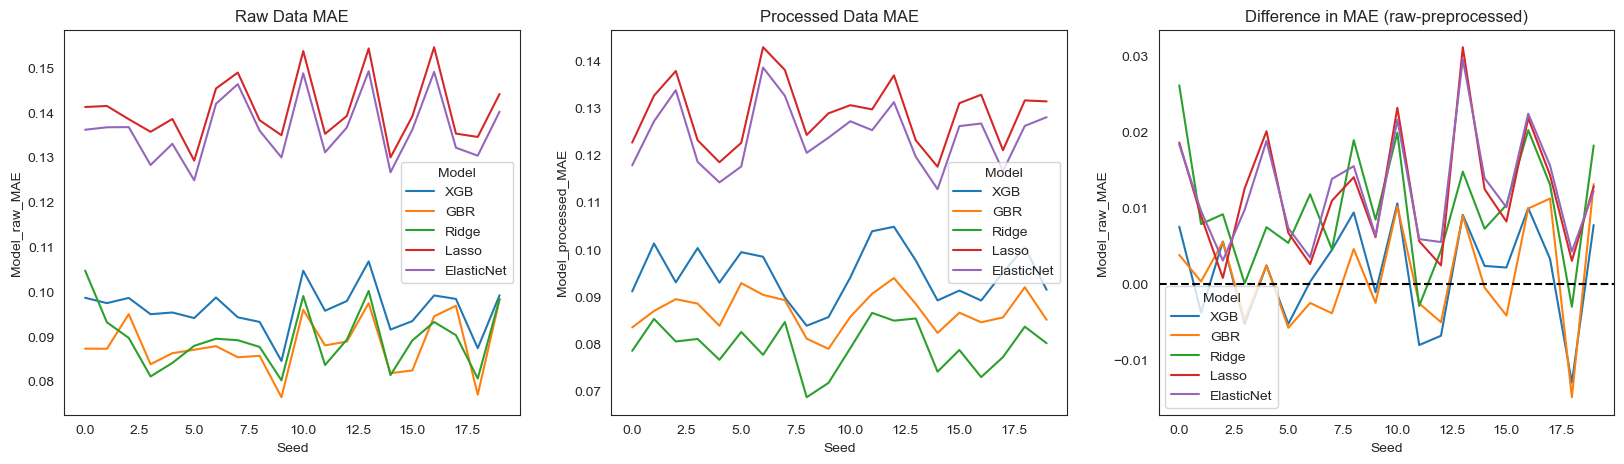

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_raw_MAE', hue='Model', data=CV, ax=ax[0])
sns.lineplot(x='Seed', y='Model_processed_MAE', hue='Model', data=CV, ax=ax[1])
CV_diff['Model_raw_MAE'] = CV_diff['Model_raw_MAE'] - CV_diff['Model_processed_MAE']
sns.lineplot(x='Seed', y='Model_raw_MAE', hue='Model', data=CV_diff, ax=ax[2])
ax[2].axhline(y=0, color='black', linestyle='--')
ax[0].set_title('Raw Data MAE')
ax[1].set_title('Processed Data MAE')
ax[2].set_title('Difference in MAE (raw-preprocessed)')
plt.show()

# Best Model for each metrics

In [45]:
df_best = pd.DataFrame(columns=['Metric', 'Model'])
df_best = df_best.append({'Metric': 'MSE', 'Model': CV.groupby('Model')['Model_raw_MSE'].mean().idxmin()}, ignore_index=True)
df_best = df_best.append({'Metric': 'RMSE', 'Model': CV.groupby('Model')['Model_raw_rmse'].mean().idxmin()}, ignore_index=True)
df_best = df_best.append({'Metric': 'RMSLE', 'Model': CV.groupby('Model')['Model_raw_rmsle'].mean().idxmin()}, ignore_index=True)
df_best = df_best.append({'Metric': 'R2', 'Model': CV.groupby('Model')['Model_raw_r2'].mean().idxmax()}, ignore_index=True)
df_best = df_best.append({'Metric': 'MAE', 'Model': CV.groupby('Model')['Model_raw_MAE'].mean().idxmin()}, ignore_index=True)
df_best = df_best.append({'Metric': 'MSE', 'Model': CV.groupby('Model')['Model_processed_MSE'].mean().idxmin()}, ignore_index=True)
df_best = df_best.append({'Metric': 'RMSE', 'Model': CV.groupby('Model')['Model_processed_rmse'].mean().idxmin()}, ignore_index=True)
df_best = df_best.append({'Metric': 'RMSLE', 'Model': CV.groupby('Model')['Model_processed_rmsle'].mean().idxmin()}, ignore_index=True)
df_best = df_best.append({'Metric': 'R2', 'Model': CV.groupby('Model')['Model_processed_r2'].mean().idxmax()}, ignore_index=True)
df_best = df_best.append({'Metric': 'MAE', 'Model': CV.groupby('Model')['Model_processed_MAE'].mean().idxmin()}, ignore_index=True)
df_best['Label'] = ['Raw', 'Raw', 'Raw', 'Raw','Raw', 'Processed', 'Processed', 'Processed', 'Processed', 'Processed']
df_best

,Metric,Model,Label
0,MSE,GBR,Raw
1,RMSE,GBR,Raw
2,RMSLE,GBR,Raw
3,R2,GBR,Raw
4,MAE,GBR,Raw
5,MSE,Ridge,Processed
6,RMSE,Ridge,Processed
7,RMSLE,Ridge,Processed
8,R2,Ridge,Processed
9,MAE,Ridge,Processed


In [46]:
mu_mse = 0

In [47]:
#group by model to see which model is the best
CV.groupby('Model').mean()

,Model_raw_MSE,Model_processed_MSE,Model_raw_rmse,Model_processed_rmse,Model_raw_rmsle,Model_processed_rmsle,Model_raw_r2,Model_processed_r2,Model_raw_MAE,Model_processed_MAE
Model,,,,,,,,,,
ElasticNet,0.041415,0.030374,0.201781,0.174058,0.015437,0.013483,0.734657,0.806847,0.136523,0.124172
GBR,0.017171,0.015529,0.130121,0.124283,0.010021,0.009645,0.890200,0.901217,0.088167,0.087017
Lasso,0.044046,0.032217,0.208160,0.179265,0.015926,0.013883,0.717896,0.795122,0.140623,0.128803
Ridge,0.021212,0.013323,0.142776,0.115018,0.010900,0.008963,0.864189,0.915265,0.089631,0.079535
XGB,0.020453,0.018340,0.142337,0.135078,0.010987,0.010511,0.869093,0.883401,0.096219,0.094668


# Compare model with preprocessed data

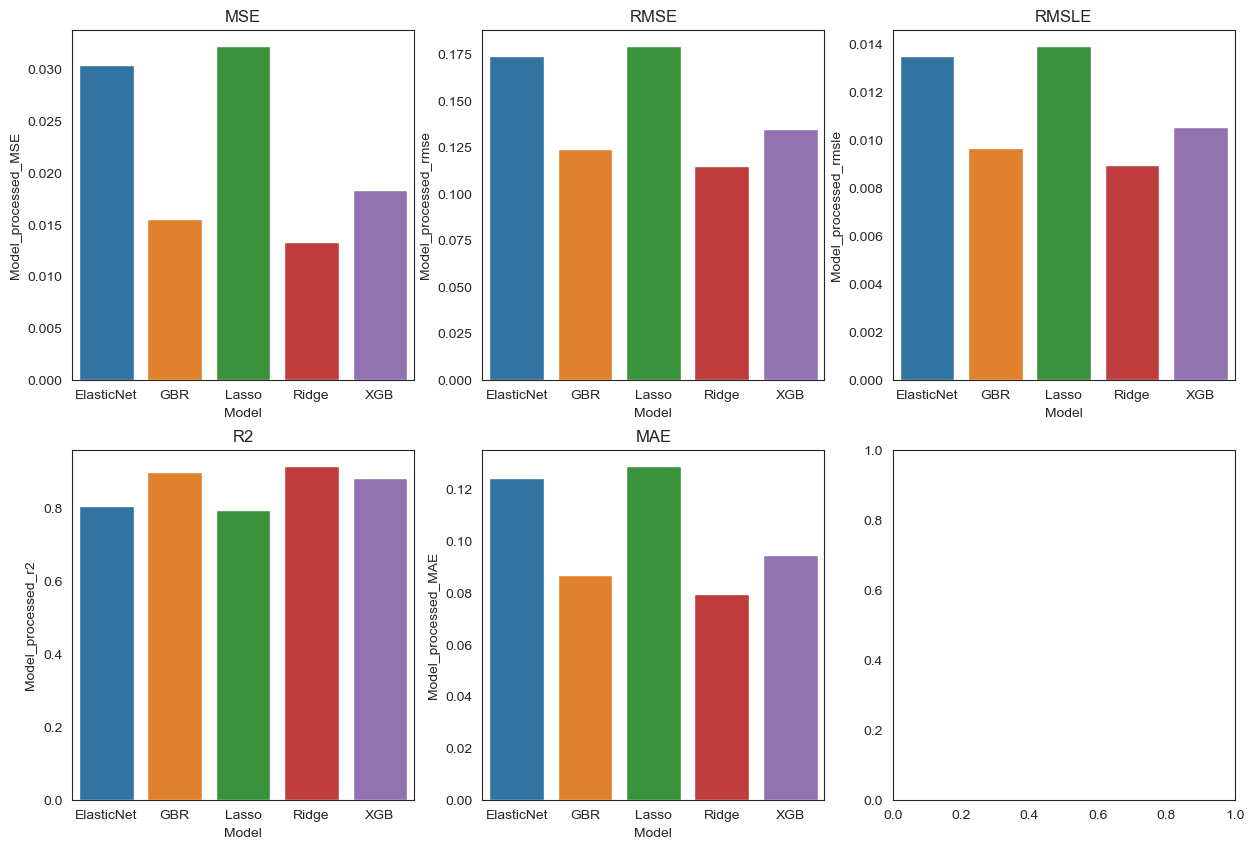

In [48]:
CV_plot = CV.groupby('Model').mean().reset_index()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.barplot(x='Model', y='Model_processed_MSE', data=CV_plot, ax=axes[0, 0])
sns.barplot(x='Model', y='Model_processed_rmse', data=CV_plot, ax=axes[0, 1])
sns.barplot(x='Model', y='Model_processed_rmsle', data=CV_plot, ax=axes[0, 2])
sns.barplot(x='Model', y='Model_processed_r2', data=CV_plot, ax=axes[1, 0])
sns.barplot(x='Model', y='Model_processed_MAE', data=CV_plot, ax=axes[1, 1])
#titles
axes[0, 0].set_title('MSE')
axes[0, 1].set_title('RMSE')
axes[0, 2].set_title('RMSLE')
axes[1, 0].set_title('R2')
axes[1, 1].set_title('MAE')
plt.show()

In [49]:
#hypothesis testing
#H0: mean of MSE of every model is the same
#H1: mean of MSE of every model is not the same
#use ANOVA test
from scipy.stats import f_oneway

# MSE (models)

In [50]:
XGB_MSE = CV[CV['Model'] == 'XGB']['Model_processed_MSE'].tolist()
GBR_MSE = CV[CV['Model'] == 'GBR']['Model_processed_MSE'].tolist()
Rid_MSE = CV[CV['Model'] == 'Ridge']['Model_processed_MSE'].tolist()
Las_MSE = CV[CV['Model'] == 'Lasso']['Model_processed_MSE'].tolist()
ElastiN_MSE = CV[CV['Model'] == 'ElasticNet']['Model_processed_MSE'].tolist()

In [51]:
f_oneway(XGB_MSE, GBR_MSE, Rid_MSE, Las_MSE, ElastiN_MSE)

F_onewayResult(statistic=194.8351432484964, pvalue=7.061871286904731e-45)

In [52]:
#ranking by mean of MSE
CV.groupby('Model').mean().sort_values(by='Model_processed_MSE')

,Model_raw_MSE,Model_processed_MSE,Model_raw_rmse,Model_processed_rmse,Model_raw_rmsle,Model_processed_rmsle,Model_raw_r2,Model_processed_r2,Model_raw_MAE,Model_processed_MAE
Model,,,,,,,,,,
Ridge,0.021212,0.013323,0.142776,0.115018,0.010900,0.008963,0.864189,0.915265,0.089631,0.079535
GBR,0.017171,0.015529,0.130121,0.124283,0.010021,0.009645,0.890200,0.901217,0.088167,0.087017
XGB,0.020453,0.018340,0.142337,0.135078,0.010987,0.010511,0.869093,0.883401,0.096219,0.094668
ElasticNet,0.041415,0.030374,0.201781,0.174058,0.015437,0.013483,0.734657,0.806847,0.136523,0.124172
Lasso,0.044046,0.032217,0.208160,0.179265,0.015926,0.013883,0.717896,0.795122,0.140623,0.128803


=> Kết luận ba mô hình cho kết quả khác nhau

mean MSE của Ridge là thấp nhất vậy Ridge cho kết quả tốt nhất (trên thước đo MSE)

# MAE (models)

In [53]:
XGB_mae = CV[CV['Model'] == 'XGB']['Model_processed_MAE'].tolist()
GBR_mae = CV[CV['Model'] == 'GBR']['Model_processed_MAE'].tolist()
Ridge_mae = CV[CV['Model'] == 'Ridge']['Model_processed_MAE'].tolist()
Lasso_mae = CV[CV['Model'] == 'Lasso']['Model_processed_MAE'].tolist()
ElasticNet_mae = CV[CV['Model'] == 'ElasticNet']['Model_processed_MAE'].tolist()
f_oneway(XGB_mae, GBR_mae, Ridge_mae, Lasso_mae, ElasticNet_mae)

F_onewayResult(statistic=288.9495363838113, pvalue=3.003653147146494e-52)

In [54]:
#ranking by mean of MAE
CV.groupby('Model').mean().sort_values(by='Model_processed_MAE')

,Model_raw_MSE,Model_processed_MSE,Model_raw_rmse,Model_processed_rmse,Model_raw_rmsle,Model_processed_rmsle,Model_raw_r2,Model_processed_r2,Model_raw_MAE,Model_processed_MAE
Model,,,,,,,,,,
Ridge,0.021212,0.013323,0.142776,0.115018,0.010900,0.008963,0.864189,0.915265,0.089631,0.079535
GBR,0.017171,0.015529,0.130121,0.124283,0.010021,0.009645,0.890200,0.901217,0.088167,0.087017
XGB,0.020453,0.018340,0.142337,0.135078,0.010987,0.010511,0.869093,0.883401,0.096219,0.094668
ElasticNet,0.041415,0.030374,0.201781,0.174058,0.015437,0.013483,0.734657,0.806847,0.136523,0.124172
Lasso,0.044046,0.032217,0.208160,0.179265,0.015926,0.013883,0.717896,0.795122,0.140623,0.128803


Tương tự, Ridge cũng cho kết quả tốt nhất (trên thước đo là MAE)

# RMSE (models)

In [55]:
XGB_rmse = CV[CV['Model'] == 'XGB']['Model_processed_rmse'].tolist()
GBR_rmse = CV[CV['Model'] == 'GBR']['Model_processed_rmse'].tolist()
Ridge_rmse = CV[CV['Model'] == 'Ridge']['Model_processed_rmse'].tolist()
Lasso_rmse = CV[CV['Model'] == 'Lasso']['Model_processed_rmse'].tolist()
ElasticNet_rmse = CV[CV['Model'] == 'ElasticNet']['Model_processed_rmse'].tolist()
f_oneway(XGB_rmse, GBR_rmse,Ridge_rmse, Lasso_rmse, ElasticNet_rmse)

F_onewayResult(statistic=190.61465912730233, pvalue=1.778706824796962e-44)

In [56]:
#ranking by mean of rmse
CV.groupby('Model').mean().sort_values(by='Model_processed_rmse')

,Model_raw_MSE,Model_processed_MSE,Model_raw_rmse,Model_processed_rmse,Model_raw_rmsle,Model_processed_rmsle,Model_raw_r2,Model_processed_r2,Model_raw_MAE,Model_processed_MAE
Model,,,,,,,,,,
Ridge,0.021212,0.013323,0.142776,0.115018,0.010900,0.008963,0.864189,0.915265,0.089631,0.079535
GBR,0.017171,0.015529,0.130121,0.124283,0.010021,0.009645,0.890200,0.901217,0.088167,0.087017
XGB,0.020453,0.018340,0.142337,0.135078,0.010987,0.010511,0.869093,0.883401,0.096219,0.094668
ElasticNet,0.041415,0.030374,0.201781,0.174058,0.015437,0.013483,0.734657,0.806847,0.136523,0.124172
Lasso,0.044046,0.032217,0.208160,0.179265,0.015926,0.013883,0.717896,0.795122,0.140623,0.128803


Tương tự, Ridge cũng cho kết quả tốt nhất (trên thước đo là RMSE)

=> mô hình Ridge hoạt động tốt nhất trên tập dữ liệu này

# raw vs preprocessed

MAE (Data)

In [57]:
with_features = CV['Model_processed_MAE'].tolist()
without_features = CV['Model_raw_MAE'].tolist()
compare = [without_features[i] - with_features[i] for i in range(len(with_features))]

In [58]:
import numpy as np
import math

dbar = np.mean(compare)
s = np.std(compare)
n = len(compare)
df = n - 1
print('dbar = ', dbar)
print('s = ', s)

dbar =  0.007393232750291411
s =  0.008813863856136226


Đặt μ là mean của toàn bộ mse của trước trừ sau tiền xử lý </br>
H0: μ=0 (hai phương pháp cho kết quả như nhau) </br>
H1: μ>0 (tiền xử lý tốt hơn phương pháp cũ) </br>

In [59]:
df

99

In [60]:
mu = 0
t_value = (dbar - mu)/(s/n**(1/2))
print(t_value)

8.388185784313233


In [61]:
from scipy.stats import t

# Tính giá trị p cho giá trị t
p_value = t.sf(t_value, df, loc=1)
print(p_value)

2.3921368140755264e-11


In [62]:
alpha = 0.05

if p_value < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau')

Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn


R2 (Data)

In [63]:
#tương tự đối với r2
with_features_r2 = CV['Model_processed_r2'].tolist()
without_features_r2 = CV['Model_raw_r2'].tolist()
compare_r2 = [with_features_r2[i] - without_features_r2[i] for i in range(len(with_features_r2))]
dbar_r2 = np.mean(compare_r2)
s_r2 = np.std(compare_r2)
n_r2 = len(compare_r2)
df_r2 = n_r2 - 1
print('dbar = ', dbar_r2)
print('s = ', s_r2)

dbar =  0.04516363757355332
s =  0.06323441381722995


In [64]:
mu_r2 = 0
t_value_r2 = (dbar_r2 - mu_r2)/(s_r2/n_r2**(1/2))
print(t_value_r2)

7.142256067098585


In [65]:
p_value_r2 = t.sf(t_value_r2, df_r2, loc=1)
print(p_value_r2)

8.512536300326018e-09


In [66]:
alpha = 0.05

if p_value_r2 < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau')

Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn


RMSE (data)

In [67]:
#tương tự đối với rmse
with_features_rmse = CV['Model_processed_rmse'].tolist()
without_features_rmse = CV['Model_raw_rmse'].tolist()
compare_rmse = [without_features_rmse[i] - with_features_rmse[i] for i in range(len(with_features_rmse))]
dbar_rmse = np.mean(compare_rmse)
s_rmse = np.std(compare_rmse)
n_rmse = len(compare_rmse)
df_rmse = n_rmse - 1
print('dbar = ', dbar_rmse)
print('s = ', s_rmse)

dbar =  0.019494782305348596
s =  0.02637394762029112


In [68]:
mu_rmse = 0
t_value_rmse = (dbar_rmse - mu_rmse)/(s_rmse/n_rmse**(1/2))
print(t_value_rmse)

7.391681588974586


In [69]:
p_value_rmse = t.sf(t_value_rmse, df_rmse, loc=1)
print(p_value_rmse)

2.7067333297528326e-09


In [70]:
alpha = 0.05

if p_value_rmse < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau (rmse)')

Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn


RMSLE (data)

In [71]:
#tương tự đối với rmsle
with_features_rmsle = CV['Model_processed_rmsle'].tolist()
without_features_rmsle = CV['Model_raw_rmsle'].tolist()
compare_rmsle = [without_features_rmsle[i] - with_features_rmsle[i] for i in range(len(with_features_rmsle))]
dbar_rmsle = np.mean(compare_rmsle)
s_rmsle = np.std(compare_rmsle)
n_rmsle = len(compare_rmsle)
df_rmsle = n_rmsle - 1
print('dbar = ', dbar_rmsle)
print('s = ', s_rmsle)

dbar =  0.0013570877977349086
s =  0.0018739166013186446


In [72]:
mu_rmsle = 0
t_value_rmsle = (dbar_rmsle - mu_rmsle)/(s_rmsle/n_rmsle**(1/2))
print(t_value_rmsle)
    

7.24198609895418


In [73]:
p_value_rmsle = t.sf(t_value_rmsle, df_rmsle, loc=1)
print(p_value_rmsle)

5.395318109046857e-09


In [74]:
alpha = 0.05

if p_value_rmsle < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau (rmsle)')

Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn


# One-hot encoding vs Label encoding

In [149]:
train_label_enc = pd.read_csv('train_label_enc.csv')

In [150]:
train_label_enc.shape, train_features.shape

((1458, 132), (1458, 377))

In [77]:
train_labels.shape

(1458,)

In [161]:
def split_evaluate_enc(dfraw, labelraw, dfprocessed, labelprocessed, n):
    output = pd.DataFrame(columns=['Seed', 'Model', 'Model_label_MSE', 'Model_processed_MSE', 
                                   'Model_label_rmse', 'Model_processed_rmse','Model_label_rmsle',
                                   'Model_processed_rmsle', 'Model_label_r2', 
                                   'Model_processed_r2', 'Model_label_MAE', 'Model_processed_MAE'])
    for i in range(0,n):
        seed = i
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(dfraw, labelraw, test_size=0.2, random_state=seed)
        X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(dfprocessed, labelprocessed, test_size=0.2, random_state=seed)
        
        for model in models:
            # modelName = 'LR' if model == models[0] else 'XGB' if model == models[1] else 'GBR' if model == models[2] else 'SVR' if model == models[3] else 'Ridge' if model == models[4] else 'Lasso' if model == models[5] else 'ElasticNet'
            modelName = 'XGB' if model == models[0] else 'GBR' if model == models[1] else 'Ridge' if model == models[2] else 'Lasso' if model == models[3] else 'ElasticNet'
            if not os.path.exists(f'models/{modelName}/label_enc'):
                os.makedirs(f'models/{modelName}/label_enc')
            model_raw = model
            model_raw.fit(X_train_raw, y_train_raw)
            joblib.dump(model_raw, open(f'models/{modelName}/label_enc/model_label_enc_{seed}.sav', 'wb'))
            y_pred_raw = model_raw.predict(X_test_raw)
            model_processed = joblib.load(open(f'models/{modelName}/preprocess_eval/model_processed_{seed}.sav', 'rb'))
            y_pred_processed = model_processed.predict(X_test_processed)
            raw_MSE = mean_squared_error(y_test_raw, y_pred_raw)
            processed_MSE = mean_squared_error(y_test_processed, y_pred_processed)
            output = output.append({
                'Seed': seed, 'Model': modelName, 'Model_label_MSE': raw_MSE, 'Model_processed_MSE': processed_MSE, 
                'Model_label_rmse': np.sqrt(raw_MSE), 'Model_processed_rmse': np.sqrt(processed_MSE), 
                'Model_label_rmsle': np.sqrt(mean_squared_log_error(y_test_raw, y_pred_raw)), 'Model_processed_rmsle': np.sqrt(mean_squared_log_error(y_test_processed, y_pred_processed)),
                'Model_label_r2': r2_score(y_test_raw, y_pred_raw), 'Model_processed_r2': r2_score(y_test_processed, y_pred_processed), 
                'Model_label_MAE': mean_absolute_error(y_test_raw, y_pred_raw), 
                'Model_processed_MAE': mean_absolute_error(y_test_processed, y_pred_processed)}, ignore_index=True)
    return output

def split_evaluate_wsaved_model_enc(dfraw,labelraw, dfprocessed, labelprocessed,n):
    output = pd.DataFrame(columns=['Seed', 'Model', 'Model_label_MSE', 'Model_processed_MSE', 
                                   'Model_label_rmse', 'Model_processed_rmse','Model_label_rmsle',
                                   'Model_processed_rmsle', 'Model_label_r2', 
                                   'Model_processed_r2', 'Model_label_MAE', 'Model_processed_MAE'])
    for i in range(0,n):
        seed = i
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(dfraw, labelraw, test_size=0.2, random_state=seed)
        X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(dfprocessed, labelprocessed, test_size=0.2, random_state=seed)

        for model in models:
            modelName = 'XGB' if model == models[0] else 'GBR' if model == models[1] else 'Ridge' if model == models[2] else 'Lasso' if model == models[3] else 'ElasticNet'
            model_raw = joblib.load(open(f'models/{modelName}/label_enc/model_label_enc_{seed}.sav', 'rb'))
            y_pred_raw = model_raw.predict(X_test_raw)
            model_processed = joblib.load(open(f'models/{modelName}/preproces_eval/model_processed_{seed}.sav', 'rb'))
            y_pred_processed = model_processed.predict(X_test_processed)
            raw_MSE = mean_squared_error(y_test_raw, y_pred_raw)
            processed_MSE = mean_squared_error(y_test_processed, y_pred_processed)
            output = output.append({
                'Seed': seed, 'Model': modelName, 'Model_raw_MSE': raw_MSE, 'Model_processed_MSE': processed_MSE, 
                'Model_raw_rmse': np.sqrt(raw_MSE), 'Model_processed_rmse': np.sqrt(processed_MSE), 
                'Model_raw_rmsle': np.sqrt(mean_squared_log_error(y_test_raw, y_pred_raw)), 'Model_processed_rmsle': np.sqrt(mean_squared_log_error(y_test_processed, y_pred_processed)),
                'Model_raw_r2': r2_score(y_test_raw, y_pred_raw), 'Model_processed_r2': r2_score(y_test_processed, y_pred_processed), 
                'Model_raw_MAE': mean_absolute_error(y_test_raw, y_pred_raw), 
                'Model_processed_MAE': mean_absolute_error(y_test_processed, y_pred_processed)}, ignore_index=True)
    return output

In [162]:
CV_enc = split_evaluate_enc(train_label_enc, train_labels, train_features, train_labels, 20)

In [163]:
CV_enc

,Seed,Model,Model_label_MSE,Model_processed_MSE,Model_label_rmse,Model_processed_rmse,Model_label_rmsle,Model_processed_rmsle,Model_label_r2,Model_processed_r2,Model_label_MAE,Model_processed_MAE
0,0,XGB,0.016844,0.016547,0.129786,0.128636,0.010116,0.010016,0.900606,0.902361,0.094395,0.091135
1,0,GBR,0.012736,0.012194,0.112854,0.110424,0.008748,0.008547,0.924849,0.928050,0.083375,0.083510
2,0,Ridge,0.012290,0.011395,0.110861,0.106750,0.008579,0.008241,0.927480,0.932759,0.079931,0.078551
3,0,Lasso,0.027601,0.027601,0.166135,0.166135,0.012878,0.012878,0.837137,0.837137,0.122617,0.122617
4,0,ElasticNet,0.025912,0.025912,0.160973,0.160973,0.012490,0.012490,0.847100,0.847100,0.117799,0.117799
5,1,XGB,0.018561,0.020167,0.136239,0.142009,0.010655,0.011097,0.883676,0.873615,0.097389,0.101269
6,1,GBR,0.015368,0.014430,0.123967,0.120124,0.009678,0.009386,0.903689,0.909567,0.090270,0.086997
7,1,Ridge,0.017515,0.015605,0.132343,0.124922,0.010367,0.009816,0.890235,0.902200,0.090984,0.085314
8,1,Lasso,0.032595,0.032595,0.180540,0.180540,0.014066,0.014066,0.795728,0.795728,0.132535,0.132535
9,1,ElasticNet,0.030638,0.030638,0.175038,0.175038,0.013647,0.013647,0.807989,0.807989,0.127119,0.127119


In [80]:
CV_enc.to_csv('CV_enc.csv', index=False)

# Label - One-Hot - Difference 

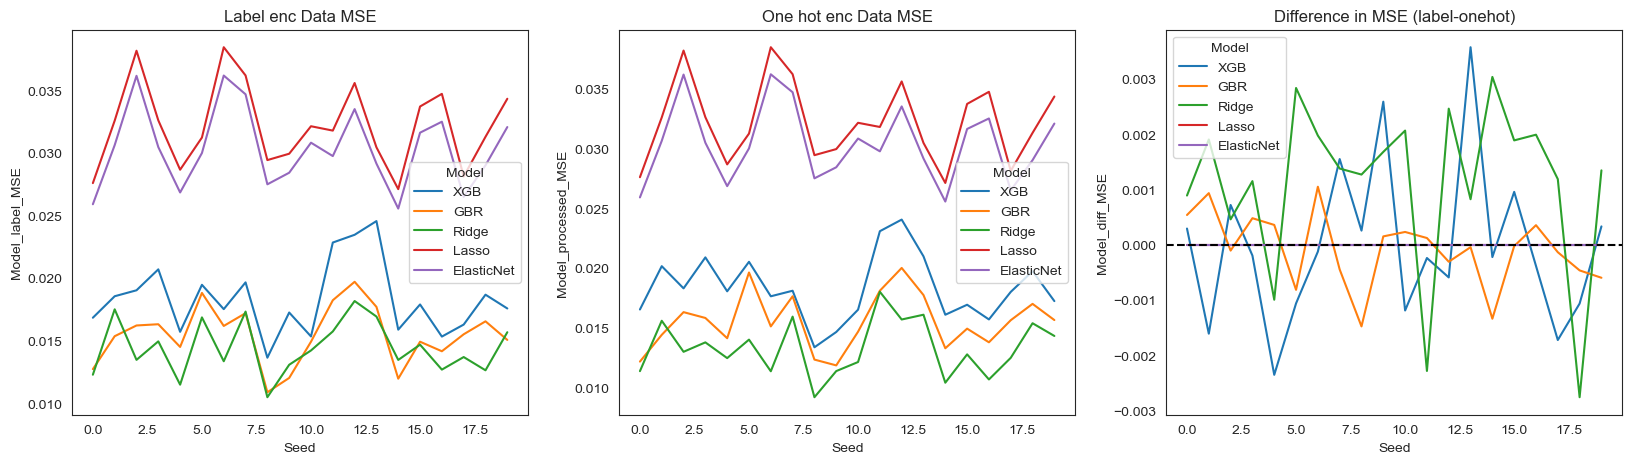

In [164]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_label_MSE', hue='Model', data=CV_enc, ax=ax[0])
sns.lineplot(x='Seed', y='Model_processed_MSE', hue='Model', data=CV_enc, ax=ax[1])
CV_diff_enc = CV_enc.copy()
CV_diff_enc['Model_diff_MSE'] = CV_diff_enc['Model_label_MSE'] - CV_diff_enc['Model_processed_MSE']
sns.lineplot(x='Seed', y='Model_diff_MSE', hue='Model', data=CV_diff_enc, ax=ax[2])
ax[2].axhline(y=0, color='black', linestyle='--')
ax[0].set_title('Label enc Data MSE')
ax[1].set_title('One hot enc Data MSE')
ax[2].set_title('Difference in MSE (label-onehot)')
plt.show()


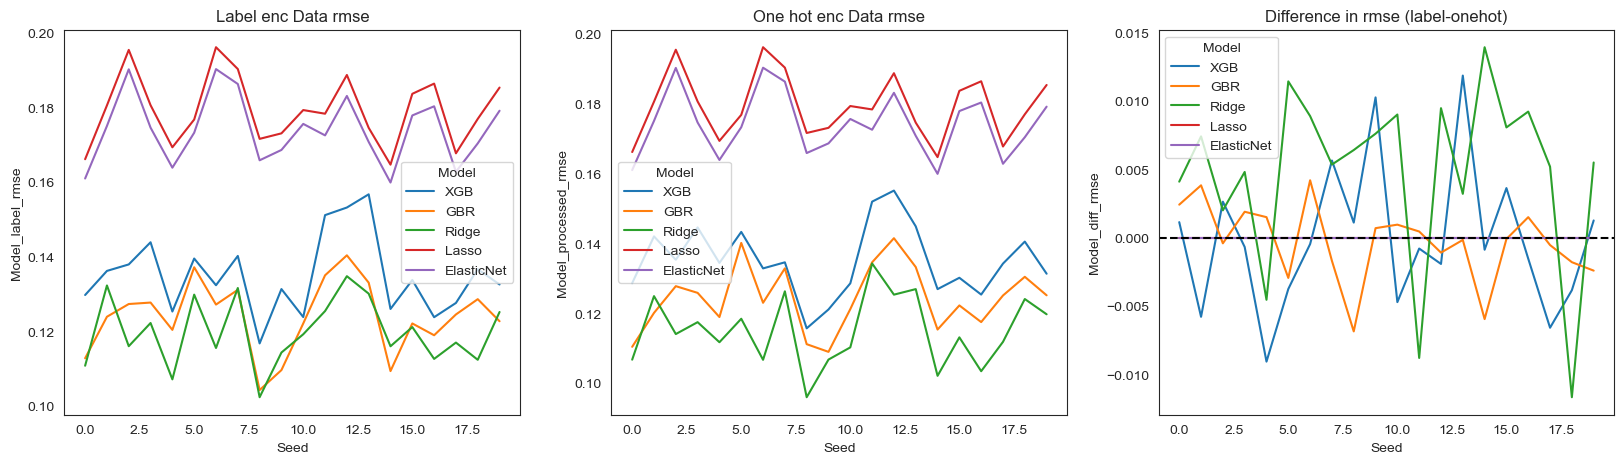

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_label_rmse', hue='Model', data=CV_enc, ax=ax[0])
sns.lineplot(x='Seed', y='Model_processed_rmse', hue='Model', data=CV_enc, ax=ax[1])
CV_diff_enc['Model_diff_rmse'] = CV_diff_enc['Model_label_rmse'] - CV_diff_enc['Model_processed_rmse']
sns.lineplot(x='Seed', y='Model_diff_rmse', hue='Model', data=CV_diff_enc, ax=ax[2])
ax[2].axhline(y=0, color='black', linestyle='--')
ax[0].set_title('Label enc Data rmse')
ax[1].set_title('One hot enc Data rmse')
ax[2].set_title('Difference in rmse (label-onehot)')
plt.show()

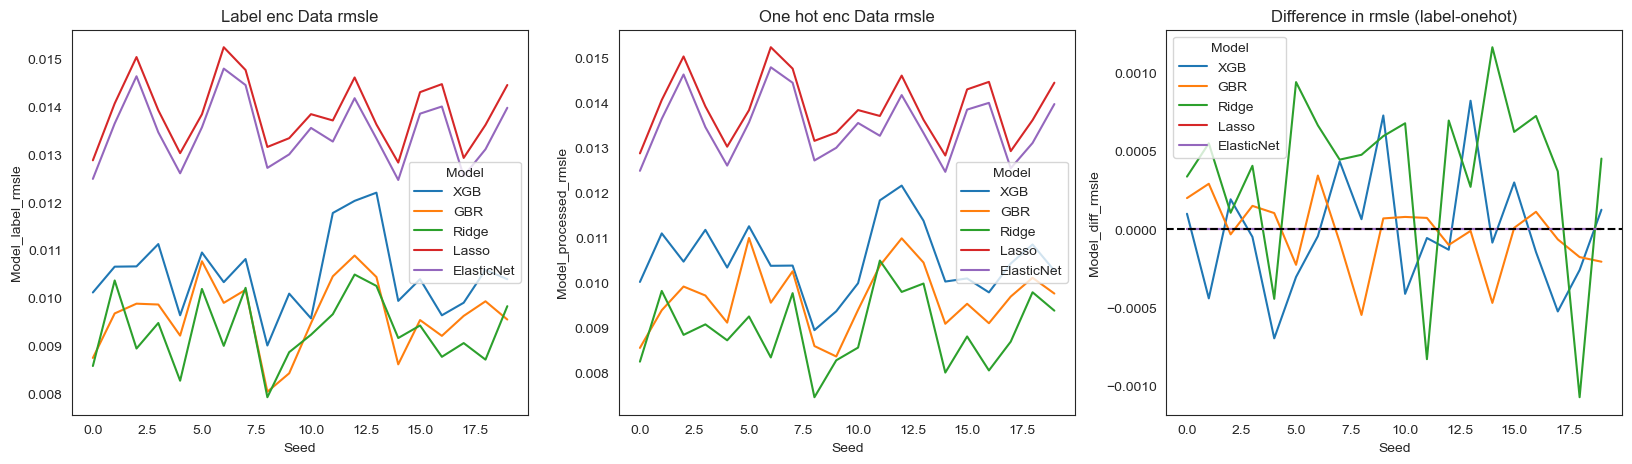

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_label_rmsle', hue='Model', data=CV_enc, ax=ax[0])
sns.lineplot(x='Seed', y='Model_processed_rmsle', hue='Model', data=CV_enc, ax=ax[1])
CV_diff_enc['Model_diff_rmsle'] = CV_diff_enc['Model_label_rmsle'] - CV_diff_enc['Model_processed_rmsle']
sns.lineplot(x='Seed', y='Model_diff_rmsle', hue='Model', data=CV_diff_enc, ax=ax[2])
ax[2].axhline(y=0, color='black', linestyle='--')
ax[0].set_title('Label enc Data rmsle')
ax[1].set_title('One hot enc Data rmsle')
ax[2].set_title('Difference in rmsle (label-onehot)')
plt.show()

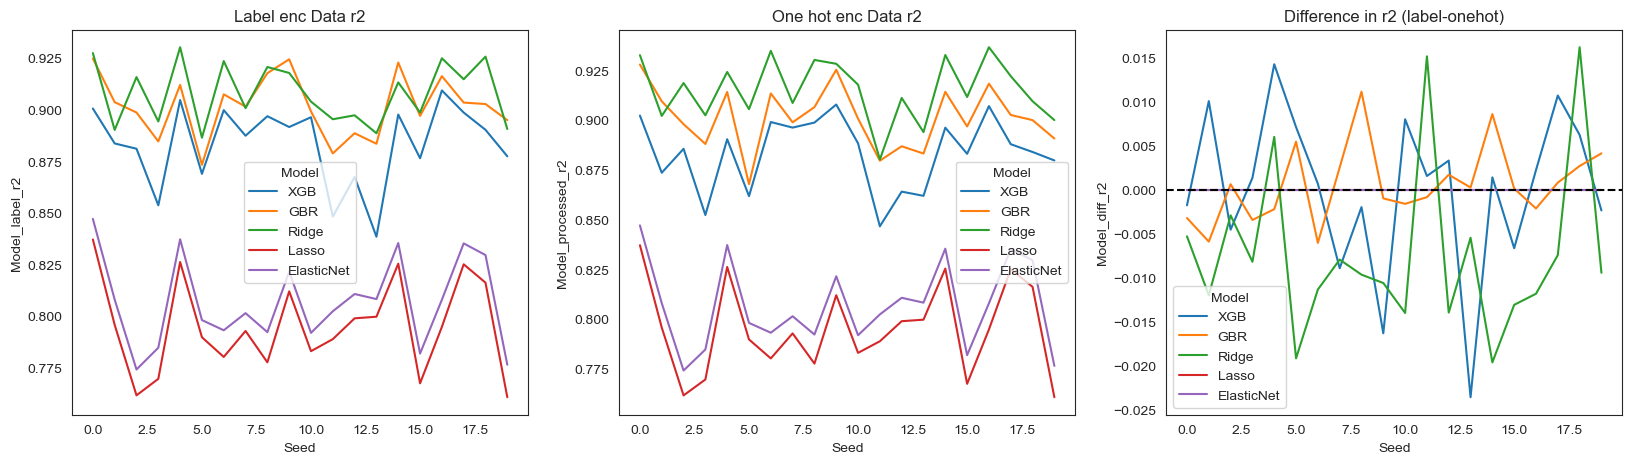

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_label_r2', hue='Model', data=CV_enc, ax=ax[0])
sns.lineplot(x='Seed', y='Model_processed_r2', hue='Model', data=CV_enc, ax=ax[1])
CV_diff_enc['Model_diff_r2'] = CV_diff_enc['Model_label_r2'] - CV_diff_enc['Model_processed_r2']
sns.lineplot(x='Seed', y='Model_diff_r2', hue='Model', data=CV_diff_enc, ax=ax[2])
ax[2].axhline(y=0, color='black', linestyle='--')   
ax[0].set_title('Label enc Data r2')
ax[1].set_title('One hot enc Data r2')
ax[2].set_title('Difference in r2 (label-onehot)')
plt.show()

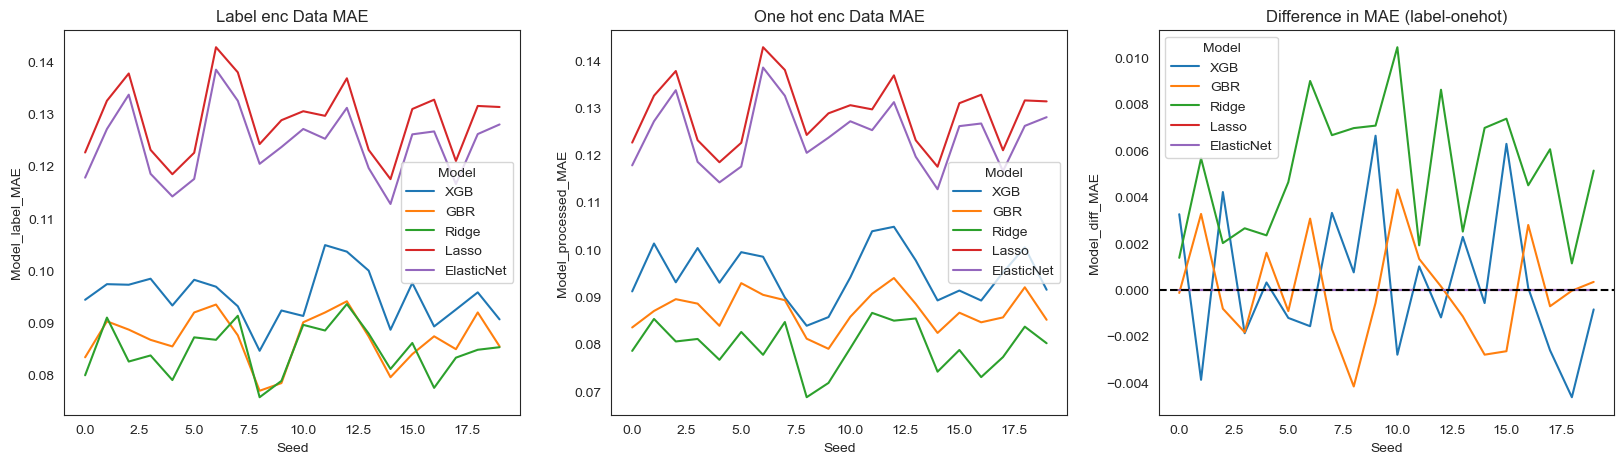

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_label_MAE', hue='Model', data=CV_enc, ax=ax[0])
sns.lineplot(x='Seed', y='Model_processed_MAE', hue='Model', data=CV_enc, ax=ax[1])
CV_diff_enc['Model_diff_MAE'] = CV_diff_enc['Model_label_MAE'] - CV_diff_enc['Model_processed_MAE']
sns.lineplot(x='Seed', y='Model_diff_MAE', hue='Model', data=CV_diff_enc, ax=ax[2])
ax[2].axhline(y=0, color='black', linestyle='--')
ax[0].set_title('Label enc Data MAE')
ax[1].set_title('One hot enc Data MAE')
ax[2].set_title('Difference in MAE (label-onehot)')
plt.show()

# Best Model for each metrics (label vs one-hot)


In [87]:
df_best_enc = pd.DataFrame(columns=['Metric', 'Model'])
df_best_enc = df_best_enc.append({'Metric': 'MSE', 'Model': CV_enc.groupby('Model')['Model_label_MSE'].mean().idxmin()}, ignore_index=True)
df_best_enc = df_best_enc.append({'Metric': 'RMSE', 'Model': CV_enc.groupby('Model')['Model_label_rmse'].mean().idxmin()}, ignore_index=True)
df_best_enc = df_best_enc.append({'Metric': 'RMSLE', 'Model': CV_enc.groupby('Model')['Model_label_rmsle'].mean().idxmin()}, ignore_index=True)
df_best_enc = df_best_enc.append({'Metric': 'R2', 'Model': CV_enc.groupby('Model')['Model_label_r2'].mean().idxmax()}, ignore_index=True)
df_best_enc = df_best_enc.append({'Metric': 'MAE', 'Model': CV_enc.groupby('Model')['Model_label_MAE'].mean().idxmin()}, ignore_index=True)
df_best_enc = df_best_enc.append({'Metric': 'MSE', 'Model': CV_enc.groupby('Model')['Model_processed_MSE'].mean().idxmin()}, ignore_index=True)
df_best_enc = df_best_enc.append({'Metric': 'RMSE', 'Model': CV_enc.groupby('Model')['Model_processed_rmse'].mean().idxmin()}, ignore_index=True)
df_best_enc = df_best_enc.append({'Metric': 'RMSLE', 'Model': CV_enc.groupby('Model')['Model_processed_rmsle'].mean().idxmin()}, ignore_index=True)
df_best_enc = df_best_enc.append({'Metric': 'R2', 'Model': CV_enc.groupby('Model')['Model_processed_r2'].mean().idxmax()}, ignore_index=True)
df_best_enc = df_best_enc.append({'Metric': 'MAE', 'Model': CV_enc.groupby('Model')['Model_processed_MAE'].mean().idxmin()}, ignore_index=True)
df_best_enc['Label'] = ['Label', 'Label', 'Label', 'Label','Label', 'Onehot', 'Onehot', 'Onehot', 'Onehot', 'Onehot']

In [88]:
df_best_enc

,Metric,Model,Label
0,MSE,Ridge,Label
1,RMSE,Ridge,Label
2,RMSLE,Ridge,Label
3,R2,Ridge,Label
4,MAE,Ridge,Label
5,MSE,Ridge,Onehot
6,RMSE,Ridge,Onehot
7,RMSLE,Ridge,Onehot
8,R2,Ridge,Onehot
9,MAE,Ridge,Onehot


Ridge hoạt động tốt nhất trên cả 2 loại encode

In [89]:
CV_enc.groupby('Model').mean()

,Model_label_MSE,Model_processed_MSE,Model_label_rmse,Model_processed_rmse,Model_label_rmsle,Model_processed_rmsle,Model_label_r2,Model_processed_r2,Model_label_MAE,Model_processed_MAE
Model,,,,,,,,,,
ElasticNet,0.030374,0.030374,0.174058,0.174058,0.013483,0.013483,0.806847,0.806847,0.124172,0.124172
GBR,0.015456,0.015529,0.123973,0.124283,0.009621,0.009645,0.901812,0.901217,0.086989,0.087017
Lasso,0.032217,0.032217,0.179265,0.179265,0.013883,0.013883,0.795122,0.795122,0.128803,0.128803
Ridge,0.014443,0.013323,0.119861,0.115018,0.009322,0.008963,0.908059,0.915265,0.084694,0.079535
XGB,0.018320,0.018340,0.134968,0.135078,0.010492,0.010511,0.883452,0.883401,0.095018,0.094668


# Label Encoding vs One-Hot Encoding testing

MSE

In [90]:
#anova test for difference in MSE  between label and onehot
label_mse = CV_enc['Model_label_MSE'].tolist()
onehot_mse = CV_enc['Model_processed_MSE'].tolist()
f_oneway(label_mse, onehot_mse)

F_onewayResult(statistic=0.03125426327982863, pvalue=0.8598550269347756)

Với alpha = 0.05 thì ta thấy cả hai loại cho kết quả như nhau

RMSE

In [91]:
#anova test for difference in RMSE  between label and onehot
label_rmse = CV_enc['Model_label_rmse'].tolist()
onehot_rmse = CV_enc['Model_processed_rmse'].tolist()
f_oneway(label_rmse, onehot_rmse)

F_onewayResult(statistic=0.05173412833899388, pvalue=0.8203074618366553)

Với alpha = 0.05 thì ta thấy cả hai loại cho kết quả như nhau 

RMSLE

In [92]:
#anova test for difference in RMSLE  between label and onehot
label_rmsle = CV_enc['Model_label_rmsle'].tolist()
onehot_rmsle = CV_enc['Model_processed_rmsle'].tolist()
f_oneway(label_rmsle, onehot_rmsle)

F_onewayResult(statistic=0.04454654269493699, pvalue=0.8330571133708354)

Với alpha = 0.05 thì ta thấy cả hai loại cho kết quả như nhau

MAE

In [93]:
#anova test for difference in R2  between label and onehot
label_r2 = CV_enc['Model_label_r2'].tolist()
onehot_r2 = CV_enc['Model_processed_r2'].tolist()
f_oneway(label_r2, onehot_r2)

F_onewayResult(statistic=0.031129006178189114, pvalue=0.8601332149274816)

Tương tự, cả hai loại cho kết quả như nhau

Vậy cả 2 loại encode đều cho kết quả như nhau

# Features Selection with ANOVA and Evaluate with each encode method

## label encode -> remove features with p-value > 0.05 -> evalute with preprocessed label encode data 

In [144]:
features_rmv_label_enc = pd.read_csv('enc_label_features_rmv.csv')
features_rmv_label_enc.head()

,x
0,MSSubClass
1,MSZoning
2,LotFrontage
3,LotArea
4,LotShape


In [145]:
train_label_enc_rmvd = pd.read_csv('train_label_encode.csv')
train_label_enc_rmvd = train_label_enc_rmvd.drop(features_rmv_label_enc['x'].tolist(), axis=1)
train_label_enc_rmvd.head()

,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrType,ExterCond,Foundation,BsmtQual,HeatingQC,CentralAir,BsmtFullBath,HalfBath,KitchenQual,Functional,PavedDrive,OpenPorchSF,MiscVal,YrSold,SaleCondition,HasOpenPorch,YearsSinceRemodel,Total_Home_Quality,YrBltAndRemod,Total_Bathrooms,Total_porch_sf,has2ndfloor,hasgarage,hasbsmt,BsmtFullBath_log,HalfBath_log,OpenPorchSF_log,MiscVal_log,YearRemodAdd_log,YearRemodAdd_sq
0,1,7,3.040151,2003,2003,12,13,1,4,2,2,0,1,0.994481,1.070981,2,6,2,12.208477,0.0,2,4,0,5,10.040151,4006,3.529971,12.208477,1,1,1,0.695385,0.732839,2.581616,0.00995,7.602905,4012009
1,1,6,4.247349,1976,1976,8,8,2,4,1,2,0,1,0.000000,0.000000,3,6,2,0.000000,0.0,1,4,1,31,10.247349,3952,2.341333,61.919825,1,1,1,0.009950,0.009950,0.009950,0.00995,7.589341,3904576
2,1,7,3.040151,2001,2002,12,13,1,4,2,2,0,1,0.994481,1.070981,2,6,2,9.995006,0.0,2,4,0,6,10.040151,4003,3.529971,9.995006,1,1,1,0.695385,0.732839,2.398350,0.00995,7.602406,4008004
3,1,7,3.040151,1915,1970,13,15,2,4,0,4,2,1,0.994481,0.000000,2,6,2,9.046382,0.0,0,0,0,36,10.040151,3885,1.994481,28.103370,1,1,1,0.695385,0.009950,2.308207,0.00995,7.586301,3880900
4,1,8,3.040151,2000,2000,12,13,1,4,2,2,0,1,0.994481,1.070981,2,6,2,14.437153,0.0,2,4,0,8,11.040151,4000,3.529971,60.573082,1,1,1,0.695385,0.732839,2.737425,0.00995,7.601407,4000000


In [165]:
train_label_enc_rmvd.shape, train_label_enc.shape

((1458, 37), (1458, 132))

In [169]:
def split_evaluate_rmv(dfraw, labelraw, dfprocessed, labelprocessed, n):
    output = pd.DataFrame(columns=['Seed', 'Model', 'Model_rmv_MSE', 'Model_base_MSE', 
                                   'Model_rmv_rmse', 'Model_base_rmse','Model_rmv_rmsle',
                                   'Model_base_rmsle', 'Model_rmv_r2', 
                                   'Model_base_r2', 'Model_rmv_MAE', 'Model_base_MAE'])
    for i in range(0,n):
        seed = i
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(dfraw, labelraw, test_size=0.2, random_state=seed)
        X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(dfprocessed, labelprocessed, test_size=0.2, random_state=seed)
        
        for model in models:
            # modelName = 'LR' if model == models[0] else 'XGB' if model == models[1] else 'GBR' if model == models[2] else 'SVR' if model == models[3] else 'Ridge' if model == models[4] else 'Lasso' if model == models[5] else 'ElasticNet'
            modelName = 'XGB' if model == models[0] else 'GBR' if model == models[1] else 'Ridge' if model == models[2] else 'Lasso' if model == models[3] else 'ElasticNet'
            if not os.path.exists(f'models/{modelName}/rmv_evaluate'):
                os.makedirs(f'models/{modelName}/rmv_evaluate')
            model_raw = model
            model_raw.fit(X_train_raw, y_train_raw)
            joblib.dump(model_raw, open(f'models/{modelName}/rmv_evaluate/model_label_enc_rmvd_{seed}.sav', 'wb'))
            y_pred_raw = model_raw.predict(X_test_raw)
            model_processed = joblib.load(open(f'models/{modelName}/label_enc/model_label_enc_{seed}.sav', 'rb'))
            y_pred_processed = model_processed.predict(X_test_processed)
            raw_MSE = mean_squared_error(y_test_raw, y_pred_raw)
            processed_MSE = mean_squared_error(y_test_processed, y_pred_processed)
            output = output.append({
                'Seed': seed, 'Model': modelName, 'Model_rmv_MSE': raw_MSE, 'Model_base_MSE': processed_MSE, 
                'Model_rmv_rmse': np.sqrt(raw_MSE), 'Model_base_rmse': np.sqrt(processed_MSE), 
                'Model_rmv_rmsle': np.sqrt(mean_squared_log_error(y_test_raw, y_pred_raw)), 'Model_base_rmsle': np.sqrt(mean_squared_log_error(y_test_processed, y_pred_processed)),
                'Model_rmv_r2': r2_score(y_test_raw, y_pred_raw), 'Model_base_r2': r2_score(y_test_processed, y_pred_processed), 
                'Model_rmv_MAE': mean_absolute_error(y_test_raw, y_pred_raw), 
                'Model_base_MAE': mean_absolute_error(y_test_processed, y_pred_processed)}, ignore_index=True)
    return output

def split_evaluate_wsaved_model_enc(dfraw,labelraw, dfprocessed, labelprocessed,n):
    output = pd.DataFrame(columns=['Seed', 'Model', 'Model_label_MSE', 'Model_processed_MSE', 
                                   'Model_label_rmse', 'Model_processed_rmse','Model_label_rmsle',
                                   'Model_processed_rmsle', 'Model_label_r2', 
                                   'Model_processed_r2', 'Model_label_MAE', 'Model_processed_MAE'])
    for i in range(0,n):
        seed = i
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(dfraw, labelraw, test_size=0.2, random_state=seed)
        X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(dfprocessed, labelprocessed, test_size=0.2, random_state=seed)

        for model in models:
            modelName = 'XGB' if model == models[0] else 'GBR' if model == models[1] else 'Ridge' if model == models[2] else 'Lasso' if model == models[3] else 'ElasticNet'
            model_raw = joblib.load(open(f'models/{modelName}/model_label_enc_{seed}.sav', 'rb'))
            y_pred_raw = model_raw.predict(X_test_raw)
            model_processed = joblib.load(open(f'models/{modelName}/model_processed_{seed}.sav', 'rb'))
            y_pred_processed = model_processed.predict(X_test_processed)
            raw_MSE = mean_squared_error(y_test_raw, y_pred_raw)
            processed_MSE = mean_squared_error(y_test_processed, y_pred_processed)
            output = output.append({
                'Seed': seed, 'Model': modelName, 'Model_raw_MSE': raw_MSE, 'Model_processed_MSE': processed_MSE, 
                'Model_raw_rmse': np.sqrt(raw_MSE), 'Model_processed_rmse': np.sqrt(processed_MSE), 
                'Model_raw_rmsle': np.sqrt(mean_squared_log_error(y_test_raw, y_pred_raw)), 'Model_processed_rmsle': np.sqrt(mean_squared_log_error(y_test_processed, y_pred_processed)),
                'Model_raw_r2': r2_score(y_test_raw, y_pred_raw), 'Model_processed_r2': r2_score(y_test_processed, y_pred_processed), 
                'Model_raw_MAE': mean_absolute_error(y_test_raw, y_pred_raw), 
                'Model_processed_MAE': mean_absolute_error(y_test_processed, y_pred_processed)}, ignore_index=True)
    return output

In [170]:
CV_enc_rmv = split_evaluate_rmv(train_label_enc_rmvd, train_labels, train_label_enc, train_labels, 20)

In [173]:
CV_enc_rmv 

,Seed,Model,Model_rmv_MSE,Model_base_MSE,Model_rmv_rmse,Model_base_rmse,Model_rmv_rmsle,Model_base_rmsle,Model_rmv_r2,Model_base_r2,Model_rmv_MAE,Model_base_MAE
0,0,XGB,0.032972,0.016844,0.181582,0.129786,0.014042,0.010116,0.805443,0.900606,0.138063,0.094395
1,0,GBR,0.028741,0.012736,0.169532,0.112854,0.013117,0.008748,0.830408,0.924849,0.133191,0.083375
2,0,Ridge,0.031894,0.012290,0.178589,0.110861,0.013769,0.008579,0.811804,0.927480,0.144808,0.079931
3,0,Lasso,0.086884,0.027601,0.294761,0.166135,0.022577,0.012878,0.487326,0.837137,0.230834,0.122617
4,0,ElasticNet,0.083023,0.025912,0.288137,0.160973,0.022083,0.012490,0.510110,0.847100,0.226042,0.117799
5,1,XGB,0.029412,0.018561,0.171500,0.136239,0.013247,0.010655,0.815671,0.883676,0.130659,0.097389
6,1,GBR,0.028131,0.015368,0.167722,0.123967,0.013027,0.009678,0.823704,0.903689,0.128769,0.090270
7,1,Ridge,0.031344,0.017515,0.177043,0.132343,0.013727,0.010367,0.803563,0.890235,0.138023,0.090984
8,1,Lasso,0.086577,0.032595,0.294240,0.180540,0.022648,0.014066,0.457415,0.795728,0.224198,0.132535
9,1,ElasticNet,0.083659,0.030638,0.289239,0.175038,0.022270,0.013647,0.475704,0.807989,0.221686,0.127119


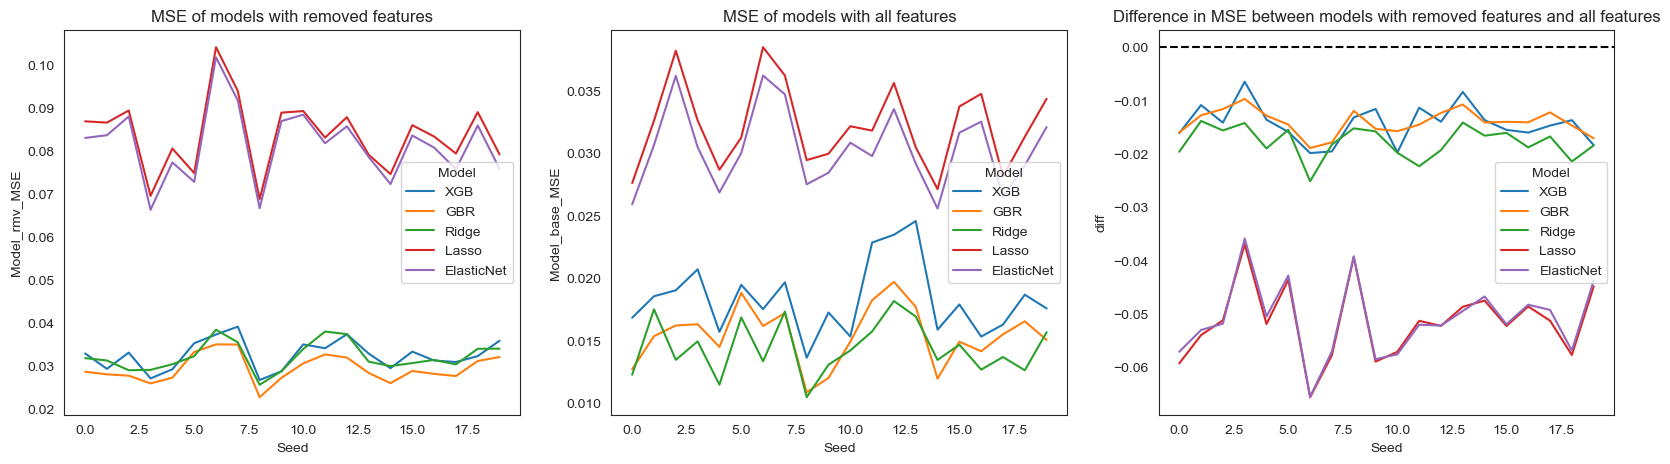

In [178]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Seed', y='Model_rmv_MSE', hue='Model', data=CV_enc_rmv, ax=ax[0])
sns.lineplot(x='Seed', y='Model_base_MSE', hue='Model', data=CV_enc_rmv, ax=ax[1])
CV_diff_enc_rmv = CV_enc_rmv.copy()
CV_diff_enc_rmv['diff'] = CV_diff_enc_rmv['Model_base_MSE'] - CV_diff_enc_rmv['Model_rmv_MSE']
sns.lineplot(x='Seed', y='diff', hue='Model', data=CV_diff_enc_rmv, ax=ax[2])
#draw a horizontal line at 0
ax[2].axhline(y=0, color='black', linestyle='--') 
ax[0].set_title('MSE of models with removed features')
ax[1].set_title('MSE of models with all features')
ax[2].set_title('Difference in MSE between models with removed features and all features')
plt.show()